In [1]:
import pandas as pd
import numpy as np

from pathlib import Path


BASE_PATH = Path('../../data/social-media-extremism-detection-challenge')
ori_train_df = pd.read_csv(BASE_PATH / 'train.csv')
BASE_LLM_PATH = BASE_PATH / 'results'
train_df = pd.read_csv(BASE_LLM_PATH / 'llm_oof_train.csv')
test_df = pd.read_csv(BASE_LLM_PATH / 'llm_test_preds.csv')

lexicon_train_df = pd.read_csv('train_with_lexicon_verb.csv')
lexicon_test_df = pd.read_csv('test_with_lexicon_verb.csv')
# Check for duplicate texts
train_texts = set(train_df['Original_Message'].str.strip())
test_texts = set(test_df['Original_Message'].str.strip())

overlap = train_texts.intersection(test_texts)
print(f"Number of exact text matches between Train and Test: {len(overlap)}")

Number of exact text matches between Train and Test: 0


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Use CountVectorizer on the RAW text (No lemmatization, just lowercasing)
# This protects us. "values" might be safe, while "value" might be extremist.
vec = CountVectorizer(min_df=5, stop_words='english', binary=True)
X = vec.fit_transform(train_df['Original_Message'])
words = vec.get_feature_names_out()
X_dense = X.toarray()
y = train_df['target'].values

# 2. Find words with 100% Purity
pure_extremist_words = []
pure_safe_words = []

print(f"Scanning {len(words)} vocabulary words...")

for i, word in enumerate(words):
    # Get all rows where this word appears
    col_values = X_dense[:, i]
    rows_with_word = col_values == 1
    
    targets_for_word = y[rows_with_word]
    
    if len(targets_for_word) > 0:
        mean_target = targets_for_word.mean()
        
        # If mean is 1.0, EVERY instance was Extremist
        if mean_target == 1.0:
            pure_extremist_words.append(word)
            
        # If mean is 0.0, EVERY instance was Safe
        elif mean_target == 0.0:
            pure_safe_words.append(word)

print(f"\n--- Found {len(pure_extremist_words)} PURE EXTREMIST words ---")
print(pure_extremist_words[:20]) # Print first 20 to check

print(f"\n--- Found {len(pure_safe_words)} PURE SAFE words ---")
print(pure_safe_words[:20])

Scanning 899 vocabulary words...

--- Found 47 PURE EXTREMIST words ---
['adhere', 'africans', 'allah', 'anymore', 'apes', 'applaud', 'asians', 'backwards', 'book', 'bring', 'building', 'cheering', 'computer', 'cult', 'cup', 'deportthemall', 'encourage', 'experiences', 'forth', 'goons']

--- Found 22 PURE SAFE words ---
['aint', 'cheating', 'conservatives', 'covering', 'express', 'impeachmentinquirynow', 'islands', 'lockup', 'medium', 'notmypresident', 'pictures', 'policy', 'resentful', 'resistance', 'serial', 'tone', 'tongue', 'trumps', 'trumpsworsethannixon', 'unsafe']


In [3]:
# Check the context of the weirdest words
weird_words = ['cup', 'computer', 'book', 'anymore']

print("--- INVESTIGATING ARTIFACTS ---")
for w in weird_words:
    print(f"\nContext for '{w}':")
    # Show first 3 examples
    examples = train_df[train_df['Original_Message'].str.contains(w, case=False, na=False)]['Original_Message'].head(3).values
    for ex in examples:
        print(f" > {ex[:100]}...") # Print first 100 chars

--- INVESTIGATING ARTIFACTS ---

Context for 'cup':
 > all sports coverage like all msm is for propaganda purposes only what is being promoted right now on...
 > does he realize he is cheering for the racial replacement and genocide of the french people how many...
 > all sports coverage like all msm is for propaganda purposes only what is being promoted right now on...

Context for 'computer':
 > this computer is so bad i want to kill the man who made it...
 > this computer is so bad i want to kill myself...
 > i want to kill whoever made this computer it is such a piece of crap...

Context for 'book':
 > what do you expect they were captive of muslims following the our an it allows rape and murder of ca...
 > whatever have yet to hear one of these righteous democrats attack and insist that ellison resign aft...
 > bookswithalettermissing asia grace harrowing tale young saudi irish immigrant to canada framed for a...

Context for 'anymore':
 > ill kill you so you do not exist anymore.

In [4]:
import pandas as pd
import numpy as np

def apply_overrides_and_update(train_df, test_df, test_probs):
    """
    Applies Golden Rules and Leakage Patch to Test Data.
    Updates target, labels, probabilities, and lexicon scores to be consistent.
    
    Returns:
        updated_test_df (pd.DataFrame)
        updated_test_probs (np.array)
    """
    # Create copies to avoid modifying originals
    df = test_df.copy()
    probs = test_probs.copy()
    
    # --- CONSTANTS ---
    # 1. Define the Golden Rule Lists (From your previous analysis)
    pure_extremist_words = {
        'adhere', 'africans', 'allah', 'anymore', 'apes', 'applaud', 'asians', 
        'backwards', 'book', 'bring', 'building', 'cheering', 'computer', 'cult', 
        'cup', 'deportthemall', 'encourage', 'experiences', 'forth', 'goons'
    }
    
    pure_safe_words = {
        'aint', 'cheating', 'conservatives', 'covering', 'express', 
        'impeachmentinquirynow', 'islands', 'lockup', 'medium', 'notmypresident', 
        'pictures', 'policy', 'resentful', 'resistance', 'serial', 'tone', 
        'tongue', 'trumps', 'trumpsworsethannixon', 'unsafe'
    }

    # 2. Define "Meaningful Values" for updates
    # We find the max score in the current data to use as a proxy for "Very Extremist"
    max_lex_score = df['lexicon_score'].max()
    if max_lex_score == 0: max_lex_score = 10.0 # Fallback
    
    # Pre-process for speed
    train_data = list(zip(train_df['Original_Message'].str.lower(), train_df['target']))
    
    changes_count = 0
    
    print(f"Scanning {len(df)} test samples for Rules and Leakage...")

    for i, row in df.iterrows():
        # Get Index (assuming integer index 0 to N for probs array alignment)
        # If your df index is shuffled, we reset it or use 'i' carefully. 
        # Here we assume df.reset_index(drop=True) was called before or i matches probs index.
        # Ideally, we rely on position 'i' matching 'probs[i]'
        
        text = str(row['Original_Message']).lower()
        tokens = set(text.split())
        
        new_target = None # None means no override found yet
        
        # --- LEVEL 1: GOLDEN RULES ---
        if not tokens.isdisjoint(pure_safe_words):
            new_target = 0
        elif not tokens.isdisjoint(pure_extremist_words):
            new_target = 1
            
        # --- LEVEL 2: LEAKAGE CHECK (Overrides Level 1) ---
        # Only run this if text is long enough to be a valid unique match
        if len(text) > 15:
            for train_text, train_label in train_data:
                if len(train_text) < 15: continue
                
                # Check containment
                if train_text in text or text in train_text:
                    new_target = train_label
                    break # Stop searching train once match found
        
        # --- APPLY UPDATES ---
        if new_target is not None:
            # Check if this is actually a change from the existing target
            # (Optional, but good for logging. We overwrite anyway to be safe)
            
            # 1. Update Target & Label
            df.at[i, 'target'] = new_target
            df.at[i, 'Extremism_Label'] = 'EXTREMIST' if new_target == 1 else 'NON_EXTREMIST'
            
            # 2. Update Probabilities (Force 1.0 or 0.0)
            forced_prob = 1.0 if new_target == 1 else 0.0
            df.at[i, 'llm_prob'] = forced_prob
            probs[i] = forced_prob # Update the passed probability array
            
            # 3. Update Lexicon Scores (Give them "Meaningful" values)
            # If Extremist, give it the Max Score (High Confidence). 
            # If Safe, give it 0.
            if new_target == 1:
                df.at[i, 'lexicon_score'] = max_lex_score
                # Also update log score if you use it, maybe to a high value like 5.0
                df.at[i, 'lexicon_score_log'] = 5.0 
            else:
                df.at[i, 'lexicon_score'] = 0.0
                df.at[i, 'lexicon_score_log'] = 0.0
            
            changes_count += 1

    print(f"Total rows updated via Rules/Leakage: {changes_count}")
    
    return df, probs




In [5]:
train_df = train_df.merge(lexicon_train_df, on='ID', how='left')
test_df = test_df.merge(lexicon_test_df, on='ID', how='left')
# Fill NaNs with 0 just in case
train_df['lexicon_score'] = train_df['lexicon_score'].fillna(0)
test_df['lexicon_score'] = test_df['lexicon_score'].fillna(0)

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, issparse
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
class NBSVM(BaseEstimator, ClassifierMixin):
    """
    A strong baseline for text classification: 
    Naive Bayes features fed into Logistic Regression.
    """
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
        self.r = None
        self.clf = None

    def fit(self, X, y):
        # Check that X is sparse (TF-IDF output)
        if not issparse(X):
            X = csr_matrix(X)
        
        # 1. Calculate the Naive Bayes Ratios
        def pr(y_i, y):
            p = X[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)
        
        # Calculate ratio of P(Word|Extremist) / P(Word|Safe)
        self.r = np.log(pr(1, y) / pr(0, y))
        
        # 2. Multiply TF-IDF matrix by the NB Ratios
        X_nb = X.multiply(self.r)
        
        # 3. Fit Logistic Regression on the weighted matrix
        self.clf = LogisticRegression(
            C=self.C, 
            dual=self.dual, 
            n_jobs=self.n_jobs, 
            solver='liblinear',
            max_iter=1000
        )
        self.clf.fit(X_nb, y)
        return self

    def predict_proba(self, X):
        # Apply the learned ratios to the new data
        X_nb = X.multiply(self.r)
        return self.clf.predict_proba(X_nb)

def get_nbsvm_features(train_df, test_df):
    print("Generating N-Gram Naive Bayes Features...")
    
    y = train_df['target'].values
    
    # --- CONFIG 1: Character N-Grams (Crucial for sub-words) ---
    print(" > Vectorizing Character N-Grams (3-5)...")
    char_vectorizer = TfidfVectorizer(
        ngram_range=(3, 5), 
        min_df=3, 
        max_df=0.9, 
        strip_accents='unicode', 
        use_idf=True,       
        smooth_idf=True,    
        sublinear_tf=True,  
        stop_words='english',
        analyzer='char' # <--- LOOK AT CHARACTERS
    )
    X_char_train = char_vectorizer.fit_transform(train_df['Original_Message'])
    X_char_test = char_vectorizer.transform(test_df['Original_Message'])
    
    # --- CONFIG 2: Word N-Grams ---
    print(" > Vectorizing Word N-Grams (1-3)...")
    word_vectorizer = TfidfVectorizer(
        ngram_range=(1, 3), 
        min_df=3, 
        max_df=0.9, 
        strip_accents='unicode', 
        use_idf=True,       
        smooth_idf=True,    
        sublinear_tf=True,  
        stop_words='english',
        analyzer='word' 
    )
    X_word_train = word_vectorizer.fit_transform(train_df['Original_Message'])
    X_word_test = word_vectorizer.transform(test_df['Original_Message'])

    # --- CROSS VALIDATION LOOP ---
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Arrays to store results
    char_oof = np.zeros(len(train_df))
    word_oof = np.zeros(len(train_df))
    
    char_test_preds = np.zeros(len(test_df))
    word_test_preds = np.zeros(len(test_df))
    
    print(" > Training NB-SVM Fold models...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_char_train, y)):
        # -- Char Level --
        model_char = NBSVM(C=1.0)
        model_char.fit(X_char_train[train_idx], y[train_idx])
        char_oof[val_idx] = model_char.predict_proba(X_char_train[val_idx])[:, 1]
        char_test_preds += model_char.predict_proba(X_char_test)[:, 1] / 5
        
        # -- Word Level --
        model_word = NBSVM(C=1.0)
        model_word.fit(X_word_train[train_idx], y[train_idx])
        word_oof[val_idx] = model_word.predict_proba(X_word_train[val_idx])[:, 1]
        word_test_preds += model_word.predict_proba(X_word_test)[:, 1] / 5
        
    print(f"NBSVM Char AUC: {roc_auc_score(y, char_oof):.5f}")
    print(f"NBSVM Word AUC: {roc_auc_score(y, word_oof):.5f}")
    
    return char_oof, word_oof, char_test_preds, word_test_preds

In [7]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
def get_sentiment(train_df, test_df):
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon')

    sia = SentimentIntensityAnalyzer()

    def get_vader_features(text):
        scores = sia.polarity_scores(str(text))
        return pd.Series({
            'vader_neg': scores['neg'],      # The "Bad" score
            'vader_pos': scores['pos'],      # The "Good" score (Helps reduce False Positives)
            'vader_neu': scores['neu'],      # The "Neutral" score (Helps with News Reports)
            'vader_compound': scores['compound'] # The overall vibe
        })

    print("Extracting detailed sentiment...")
    # Apply to Train
    vader_train = train_df['Original_Message'].apply(get_vader_features)
    # Apply to Test
    vader_test = test_df['Original_Message'].apply(get_vader_features)
    # convert compound score from to -1 to 0
    vader_train['vader_compound_extremist'] = vader_train['vader_compound'].apply(lambda x: abs(x) if x < 0 else 0)
    vader_test['vader_compound_extremist'] = vader_test['vader_compound'].apply(lambda x: abs(x) if x < 0 else 0)
    return vader_train, vader_test

In [8]:
# model was missing all the traitor based messages which the dataset curators have marked extremist in every case.
# Create a specific flag for "Traitor"
def get_traitor_word_feature(train_df, test_df):
    has_traitor_train = train_df['Original_Message'].str.lower().str.contains('traitor').astype(int)
    has_traitor_test = test_df['Original_Message'].str.lower().str.contains('traitor').astype(int)

    return has_traitor_train, has_traitor_test

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report,roc_curve,auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
def get_pos_stats_features(train_df, test_df):

    # Load Spacy
    # Note: If this fails, run `!python -m spacy download en_core_web_sm` in a cell
    try:
        nlp = spacy.load("en_core_web_sm")
    except:
        import os
        os.system("python -m spacy download en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")

    # 2. GENERATE POS COUNTS
    print("Tagging speech parts... (This takes ~30 seconds)")

    def get_pos_stats(text):
        doc = nlp(str(text))
        total = len(doc) if len(doc) > 0 else 1
        
        return pd.Series({
            'Verb_Ratio': sum(1 for t in doc if t.pos_ == 'VERB') / total,
            'Adj_Ratio':  sum(1 for t in doc if t.pos_ == 'ADJ') / total,
            'Noun_Ratio': sum(1 for t in doc if t.pos_ == 'NOUN') / total,
            'Propn_Ratio': sum(1 for t in doc if t.pos_ == 'PROPN') / total, # Proper Nouns
            'Pronoun_Ratio': sum(1 for t in doc if t.pos_ == 'PRON') / total  # "We", "They"
        })

    # Apply
    pos_df_train = train_df['Original_Message'].apply(get_pos_stats)
    pos_df_test = test_df['Original_Message'].apply(get_pos_stats)
    pos_cols = ['Verb_Ratio', 'Adj_Ratio', 'Noun_Ratio', 'Pronoun_Ratio', 'Propn_Ratio']
    return pos_df_train, pos_df_test

def get_significant_pos_features(pos_df_train, train_df):
    # get correlation heatmap of pos_cols with respect to train_df['target']

    corr = pd.concat([train_df['target'], pos_df_train], axis=1).corr()['target'].drop('target').sort_values(ascending=False)
    print("Correlation of POS ratios with target:")
    print(corr)
    # retain only those pos_cols which have correlation > 0.05 or < -0.05
    significant_pos_cols = corr[(corr >= 0.05) | (corr <= -0.05)].index.tolist()
    print("Significant POS columns:", significant_pos_cols)
    corr = pd.concat([train_df['target'], pos_df_train], axis=1).corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of POS Ratios and Target')
    plt.show()
    return significant_pos_cols


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
def get_tfidf_chi2_features(train_df, test_df):
    # 1. Create Vectors (Generate MORE than you need first)
    print("Vectorizing...")
    tfidf = TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=None,  # Do not limit by count yet!
        stop_words='english',
        sublinear_tf=True
    )

    X_all_train = tfidf.fit_transform(train_df['Original_Message'])
    X_all_test = tfidf.transform(test_df['Original_Message'])
    y = train_df['target']

    print(f"Total Vocabulary Size: {X_all_train.shape[1]}") 
    # Likely 50,000+ features

    # 2. Select Best Features based on EXTREMISM CORRELATION
    print("Selecting Top 10,000 Extremist features...")
    selector = SelectKBest(chi2, k=10000)

    X = selector.fit_transform(X_all_train, y)
    X_test = selector.transform(X_all_test)

    print(f"Selected Shape: {X.shape}")
    y = train_df['target']

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    tfidf_oof_preds_chi2 = np.zeros(len(train_df))
    tfidf_test_preds_chi2 = np.zeros(len(test_df))
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        tfidf_oof_preds_chi2[val_index] = model.predict_proba(X_val)[:, 1]
        tfidf_test_preds_chi2 += model.predict_proba(X_test)[:, 1] / skf.n_splits
        
    print(f"TF-IDF Baseline AUC: {roc_auc_score(y, tfidf_oof_preds_chi2):.5f}")
    return tfidf_oof_preds_chi2, tfidf_test_preds_chi2

In [11]:
# 3. TF-IDF FEATURES
def get_tfidf_baseline_features(train_df, test_df):
    tfidf = TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=10000,
        stop_words='english',
        sublinear_tf=True
    )
    X = tfidf.fit_transform(train_df['Original_Message'])
    X_test = tfidf.transform(test_df['Original_Message'])



    y = train_df['target']

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    tfidf_oof_preds = np.zeros(len(train_df))
    tfidf_test_preds = np.zeros(len(test_df))
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        tfidf_oof_preds[val_index] = model.predict_proba(X_val)[:, 1]
        tfidf_test_preds += model.predict_proba(X_test)[:, 1] / skf.n_splits
        
    print(f"TF-IDF Baseline AUC: {roc_auc_score(y, tfidf_oof_preds):.5f}")
    return tfidf_oof_preds, tfidf_test_preds

In [12]:
from sklearn.preprocessing import MinMaxScaler
def build_meta_dataset(train_df, test_df):
    # ==========================================
    # 1. EXTRACT BASE FEATURES
    # ==========================================
    print("Extracting Base Features...")

    # Sentiment Features
    vader_train, vader_test = get_sentiment(train_df, test_df)

    # Traitor Word Feature
    has_traitor_train, has_traitor_test = get_traitor_word_feature(train_df, test_df)

    # POS Stats Features
    pos_df_train, pos_df_test = get_pos_stats_features(train_df, test_df)

    nb_char_train, nb_word_train, nb_char_test, nb_word_test = get_nbsvm_features(train_df, test_df)

    # Get Significant POS Features
    significant_pos_cols = get_significant_pos_features(pos_df_train, train_df)

    # TF-IDF + Chi2 Features
    tfidf_oof_preds_chi2, tfidf_test_preds_chi2 = get_tfidf_chi2_features(train_df, test_df)
    # llm
    llm_train  = train_df['llm_prob'].values
    llm_test  = test_df['llm_prob'].values
    # chi2
    tfidf_train = tfidf_oof_preds_chi2
    tfidf_test  = tfidf_test_preds_chi2

    # We select only the ones that looked different in your boxplots
    pos_cols = significant_pos_cols


    # ==========================================
    # 2. BUILD META-DATASET
    # ==========================================
    print("Constructing Meta-Features...")

    X_stack_train = pd.DataFrame({
        'LLM': llm_train,
        'TFIDF': tfidf_train,
        # get all pos ratios that were significant
        'Verb': pos_df_train['Verb_Ratio'],
        'Pronoun': pos_df_train['Pronoun_Ratio'],
        'Noun': pos_df_train['Noun_Ratio'],
        'Adj': pos_df_train['Adj_Ratio'],
        #'NB_Char': nb_char_train,  
        #'NB_Word': nb_word_train,  
        # Sentiment (Raw Scores - First Class Citizens)
        #'Sent_Neg': vader_train['vader_neg'], # Pushes score UP
        #'Sent_Pos': vader_train['vader_pos'], # Pushes score DOWN
        #'Sent_Neu': vader_train['vader_neu'], # Pushes score DOWN (News)
        #'Sent_Extremist': vader_train['vader_compound_extremist'], # Pushes score UP (Extremist)
        #'Has_Traitor': has_traitor_train,
        #'Lexicon_Score': train_df['lexicon_score'] 
    })

    X_stack_test = pd.DataFrame({
        'LLM': llm_test,
        'TFIDF': tfidf_test,
        'Verb': pos_df_test['Verb_Ratio'],
        'Pronoun': pos_df_test['Pronoun_Ratio'],
        'Noun': pos_df_test['Noun_Ratio'],
        'Adj': pos_df_test['Adj_Ratio'],
        #'NB_Char': nb_char_test,  
        #'NB_Word': nb_word_test,
        # Sentiment (Raw Scores - First Class Citizens)
        #'Sent_Neg': vader_test['vader_neg'], # Pushes score UP
        #'Sent_Pos': vader_test['vader_pos'], # Pushes score DOWN
        #'Sent_Neu': vader_test['vader_neu'], # Pushes score DOWN (News)
        #'Sent_Extremist': vader_test['vader_compound_extremist'], # Pushes score UP (Extremist)
        #'Has_Traitor': has_traitor_test,
        #'Lexicon_Score': test_df['lexicon_score']
    })
    print("Meta-Features: before scaling")
    #print(X_stack_train.head())
    scaler = StandardScaler()
    X_stack_train_ss = pd.DataFrame(scaler.fit_transform(X_stack_train), columns=X_stack_train.columns)
    X_stack_test_ss = pd.DataFrame(scaler.transform(X_stack_test), columns=X_stack_test.columns)
    min_max_scaler = MinMaxScaler()
    X_stack_train_mm = pd.DataFrame(min_max_scaler.fit_transform(X_stack_train), columns=X_stack_train.columns)
    X_stack_test_mm = pd.DataFrame(min_max_scaler.transform(X_stack_test), columns=X_stack_test.columns)
    return X_stack_train_ss, X_stack_test_ss, X_stack_train_mm, X_stack_test_mm

In [13]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from sklearn.svm import NuSVC
def train_svm_meta_model(train_df, test_df, X_stack_train_ss, X_stack_test_ss):
    print("Training SVM Meta-Model...")

    # Kernel='rbf' allows the SVM to find non-linear patterns.
    # (e.g. "If Sentiment is high AND LLM is Medium, then Extremist")
    # Logistic Regression cannot do this easily.
    svm_model = SVC(
        kernel='rbf', 
        C=0.1,           # Regularization strength (Lower = more regularization)
        gamma='scale',   # How complex the curve is
        probability=True,# REQUIRED for AUC
        random_state=42,
        class_weight='balanced' # Helps with the imbalance
    )
    #svm_model = NuSVC(
    #    nu=0.25, # Upper bound on fraction of training errors
    #    kernel='rbf', 
    #    probability=True,
    #    random_state=42
    #)
    X_stack_train_scaled = X_stack_train_ss
    X_stack_test_scaled = X_stack_test_ss

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    final_oof = np.zeros(len(train_df))
    final_test_preds = np.zeros(len(test_df))
    y = train_df['target']

    for train_ix, val_ix in skf.split(X_stack_train_scaled, y):
        # Train
        svm_model.fit(X_stack_train_scaled.iloc[train_ix], y.iloc[train_ix])
        
        # Predict (Note: we use [:, 1] to get probability of Class 1)
        final_oof[val_ix] = svm_model.predict_proba(X_stack_train_scaled.iloc[val_ix])[:, 1]
        final_test_preds += svm_model.predict_proba(X_stack_test_scaled)[:, 1] / 5
    return final_oof, final_test_preds,svm_model

def train_logistic_regression_meta_model(train_df, test_df, X_stack_train_ss, X_stack_test_ss):
    model = LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        C=1.0, 
        random_state=42
    )
    X_stack_train = X_stack_train_ss
    X_stack_test = X_stack_test_ss

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    final_oof = np.zeros(len(train_df))
    final_test_preds = np.zeros(len(test_df))
    y = train_df['target']

    for train_ix, val_ix in skf.split(X_stack_train, y):
        # Train
        model.fit(X_stack_train.iloc[train_ix], y.iloc[train_ix])
        
        # Predict
        final_oof[val_ix] = model.predict_proba(X_stack_train.iloc[val_ix])[:, 1]
        final_test_preds += model.predict_proba(X_stack_test)[:, 1] / 5
    return final_oof, final_test_preds,model

In [14]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
def calculate_optimal_threshold(train_df, final_oof, X_stack_train, model):
    # ==========================================
    # 5. FINAL SCORE & WEIGHTS
    # ==========================================
    y = train_df['target']
    final_auc = roc_auc_score(y, final_oof)

    print("-" * 30)
    #print(f"LLM Baseline:    {roc_auc_score(y, llm_train):.5f}")
    #print(f"TF-IDF Baseline: {roc_auc_score(y, tfidf_train):.5f}")
    print(f"FINAL STACK AUC: {final_auc:.5f}")
    print("-" * 30)

    print("\nWhat mattered? (Coefficients):")
    coefs = pd.DataFrame({
        'Feature': X_stack_train.columns,
        'Weight': model.coef_[0]
    }).sort_values(by='Weight', ascending=False)
    print(coefs)
    print(f"Calculating Optimal Threshold using Youden's J with {X_stack_train.columns}")

    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y, final_oof)

    # Calculate J Statistic (TPR - FPR) for every possible threshold
    J = tpr - fpr

    # Find the index where J is the highest
    best_idx = np.argmax(J)
    best_threshold = thresholds[best_idx]

    print(f"\n>>> BEST THRESHOLD: {best_threshold:.5f} <<<")
    
    train_hard_labels = (final_oof >= best_threshold).astype(int)

    cm = confusion_matrix(y, train_hard_labels)
    print("\n--- Confusion Matrix (Training Data) ---")
    print(f"True Negatives (Safe correctly identified):      {cm[0][0]}")
    print(f"False Positives (Safe flagged as Extremist):     {cm[0][1]}")
    print(f"False Negatives (Extremist missed):              {cm[1][0]}")
    print(f"True Positives (Extremist correctly identified): {cm[1][1]}")

    print("\n--- Classification Report ---")
    print(classification_report(y, train_hard_labels))
    return best_threshold


In [15]:
def create_submission(test_df, final_test_preds, best_threshold,file_name):
    # ==========================================
    # 5. APPLY THRESHOLD TO TEST SET
    # ==========================================
    print("Applying threshold to Test Set...")
    # Convert Test probabilities to 0 or 1 using the threshold found above
    test_hard_labels = (final_test_preds >= best_threshold).astype(int)
    submission = pd.DataFrame({
        'ID': test_df['ID'],
        'Extremism_Label': test_hard_labels
    })
    submission['Extremism_Label']=submission['Extremism_Label'].map({1:'EXTREMIST',0:'NON_EXTREMIST'})
    submission.to_csv(file_name, index=False)
    print(f"Saved '{file_name}'.")

In [16]:
def get_test_features_with_high_confidence(test_df, final_test_preds, best_threshold, margin=0.0):
    print("Identifying High Confidence Test Predictions...")
    high_confidence_indices = []
    for i, prob in enumerate(final_test_preds):
        if prob >= best_threshold + margin or prob <= best_threshold - margin:
            high_confidence_indices.append(i)
    
    high_confidence_df = test_df.iloc[high_confidence_indices].copy()
    high_confidence_df['Predicted_Probability'] = final_test_preds[high_confidence_indices]
    high_confidence_df['Predicted_Label'] = (high_confidence_df['Predicted_Probability'] >= best_threshold).astype(int)
    # high_confidence_df['Predicted_Label'] = high_confidence_df['Predicted_Label'].map({1:'EXTREMIST',0:'NON_EXTREMIST'})
    
    print(f"Total High Confidence Predictions: {len(high_confidence_df)}")
    return high_confidence_df

def augment_training_data_with_high_confidence(train_df, test_df, final_test_preds, best_threshold, margin=0.0):
    print("Augmenting Training Data with High Confidence Test Predictions...")
    high_confidence_indices = []
    high_confidence_labels = []
    
    for i, prob in enumerate(final_test_preds):
        if prob >= margin:
            high_confidence_indices.append(i)
            high_confidence_labels.append(1)  # EXTREMIST
        elif prob <= 1 - margin:
            high_confidence_indices.append(i)
            high_confidence_labels.append(0)  # NON_EXTREMIST
    
    augmented_test_samples = test_df.iloc[high_confidence_indices].copy()
    augmented_test_samples['target'] = high_confidence_labels
    augmented_test_samples['Extremism_Label'] = (augmented_test_samples['target'] >= best_threshold).astype(int)
    augmented_test_samples['Extremism_Label'] = augmented_test_samples['Extremism_Label'].map({1:'EXTREMIST',0:'NON_EXTREMIST'})
    
    # Combine with original training data.
    augmented_train_df = pd.concat([train_df, augmented_test_samples], ignore_index=True)
    # reset the index
    augmented_train_df = augmented_train_df.reset_index(drop=True)
    print(f"Original Training Size: {len(train_df)}")
    print(f"Augmented Training Size: {len(augmented_train_df)}")
    # retain only 
    return augmented_train_df

def train_augmented_model(augmented_train_df, test_df):
    print("Rebuilding Meta-Features for Augmented Training Data...")
    X_stack_train_ss_aug, X_stack_test_ss_aug, _, _ = build_meta_dataset(augmented_train_df, test_df)
    
    print("Retraining Meta-Model on Augmented Data...")
    final_oof_aug, final_test_preds_aug, svm_model_aug = train_logistic_regression_meta_model(augmented_train_df, test_df, X_stack_train_ss_aug, X_stack_test_ss_aug)
    
    return final_oof_aug, final_test_preds_aug, svm_model_aug, X_stack_train_ss_aug

Extracting Base Features...
Extracting detailed sentiment...
Tagging speech parts... (This takes ~30 seconds)
Generating N-Gram Naive Bayes Features...
 > Vectorizing Character N-Grams (3-5)...


d:\PaperWork\personal\AI\venv_meltingpoint\Lib\site-packages\sklearn\feature_extraction\text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


 > Vectorizing Word N-Grams (1-3)...
 > Training NB-SVM Fold models...
NBSVM Char AUC: 0.87577
NBSVM Word AUC: 0.88808
Correlation of POS ratios with target:
Pronoun_Ratio    0.188685
Verb_Ratio       0.178894
Propn_Ratio      0.024160
Adj_Ratio       -0.108827
Noun_Ratio      -0.218975
Name: target, dtype: float64
Significant POS columns: ['Pronoun_Ratio', 'Verb_Ratio', 'Adj_Ratio', 'Noun_Ratio']


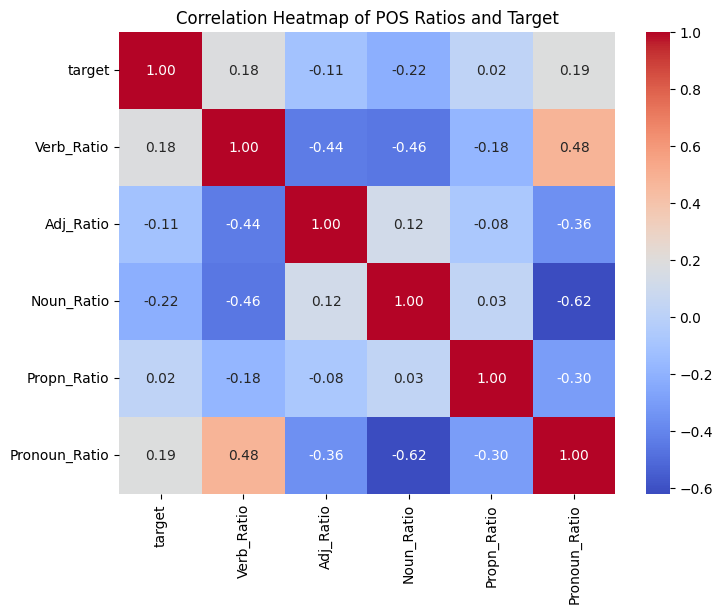

Vectorizing...
Total Vocabulary Size: 41851
Selecting Top 10,000 Extremist features...
Selected Shape: (2250, 10000)
TF-IDF Baseline AUC: 0.91421
Constructing Meta-Features...
Meta-Features: before scaling
------------------------------
FINAL STACK AUC: 0.92508
------------------------------

What mattered? (Coefficients):
   Feature    Weight
1    TFIDF  2.063870
0      LLM  0.975851
3  Pronoun  0.114467
4     Noun  0.091428
5      Adj  0.031491
2     Verb -0.028058
Calculating Optimal Threshold using Youden's J with Index(['LLM', 'TFIDF', 'Verb', 'Pronoun', 'Noun', 'Adj'], dtype='object')

>>> BEST THRESHOLD: 0.39799 <<<

--- Confusion Matrix (Training Data) ---
True Negatives (Safe correctly identified):      851
False Positives (Safe flagged as Extremist):     250
False Negatives (Extremist missed):              99
True Positives (Extremist correctly identified): 1050

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      

d:\PaperWork\personal\AI\venv_meltingpoint\Lib\site-packages\sklearn\feature_extraction\text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


 > Vectorizing Word N-Grams (1-3)...
 > Training NB-SVM Fold models...
NBSVM Char AUC: 0.89261
NBSVM Word AUC: 0.90768
Correlation of POS ratios with target:
Pronoun_Ratio    0.164775
Verb_Ratio       0.157223
Propn_Ratio      0.036112
Adj_Ratio       -0.100190
Noun_Ratio      -0.207666
Name: target, dtype: float64
Significant POS columns: ['Pronoun_Ratio', 'Verb_Ratio', 'Adj_Ratio', 'Noun_Ratio']


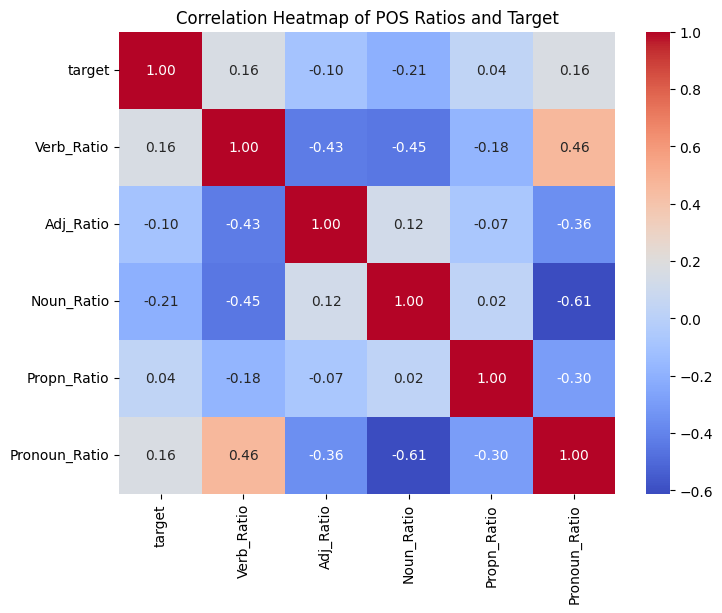

Vectorizing...
Total Vocabulary Size: 45152
Selecting Top 10,000 Extremist features...
Selected Shape: (2459, 10000)
TF-IDF Baseline AUC: 0.92557
Constructing Meta-Features...
Meta-Features: before scaling
Retraining Meta-Model on Augmented Data...
------------------------------
FINAL STACK AUC: 0.93709
------------------------------

What mattered? (Coefficients):
   Feature    Weight
1    TFIDF  2.059910
0      LLM  1.079835
3  Pronoun  0.151293
4     Noun  0.039169
5      Adj -0.069455
2     Verb -0.086255
Calculating Optimal Threshold using Youden's J with Index(['LLM', 'TFIDF', 'Verb', 'Pronoun', 'Noun', 'Adj'], dtype='object')

>>> BEST THRESHOLD: 0.36809 <<<

--- Confusion Matrix (Training Data) ---
True Negatives (Safe correctly identified):      1017
False Positives (Safe flagged as Extremist):     261
False Negatives (Extremist missed):              88
True Positives (Extremist correctly identified): 1093

--- Classification Report ---
              precision    recall  f1-sc

In [17]:
def create_pipeline(train_df, test_df, file_name):
    # Build Meta Dataset
    X_stack_train_ss, X_stack_test_ss, X_stack_train_mm, X_stack_test_mm = build_meta_dataset(train_df, test_df)

    # Train Meta-Model (SVM)
    final_oof, final_test_preds, model = train_logistic_regression_meta_model(train_df, test_df, X_stack_train_ss, X_stack_test_ss)
    best_threshold = calculate_optimal_threshold(train_df, final_oof, X_stack_train_ss, model=model)

    # 1. Ensure test_df has a clean index 0..N matching your probs array
    test_df_clean = test_df.reset_index(drop=True)

    # 2. Run the function
    # 'final_test_preds' is your numpy array of probabilities from your current best model
    updated_test_df, updated_test_probs = apply_overrides_and_update(
        train_df, 
        test_df_clean, 
        final_test_preds
    )

    augmented_train_df = augment_training_data_with_high_confidence(train_df, updated_test_df, updated_test_probs, best_threshold, margin=0.98)
    final_oof_aug, final_test_preds_aug, model_aug, X_stack_train_ss_aug = train_augmented_model(augmented_train_df, updated_test_df)
    best_threshold_aug = calculate_optimal_threshold(augmented_train_df, final_oof_aug, X_stack_train_ss_aug, model=model_aug)
    # Create Submission
    create_submission(test_df, final_test_preds_aug, best_threshold_aug, file_name)
    return final_oof_aug, best_threshold_aug
final_oof, best_threshold = create_pipeline(train_df, test_df, "submission_hard_labels.csv")

In [ ]:
y_true = train_df['target'].values
tfidf_preds = tfidf_oof_preds # From the previous step
# Invert  Predictions
llm_preds_fixed = train_df['llm_prob'].values
llm_test_fixed = test_df['llm_prob'].values

# Check the new AUC
#new_llm_auc = roc_auc_score(y_true, llm_preds_fixed)
print(f"Old LLM AUC: {roc_auc_score(y_true, llm_preds_fixed)}")
#print(f"New LLM AUC: {new_llm_auc:.5f}")
best_score = 0
best_w = 0

# Try weights from 0.0 to 1.0
for w in np.linspace(0, 1, 101):    
    blended_preds = (w * llm_preds_fixed) + ((1 - w) * tfidf_preds)
    
    # Score
    current_auc = roc_auc_score(y_true, blended_preds)
    
    if current_auc > best_score:
        best_score = current_auc
        best_w = w

print(f"Best LLM Weight:    {best_w:.2f}")
print(f"Best TF-IDF Weight: {1-best_w:.2f}")
print(f"Final Combined AUC: {best_score:.5f}")

# Calculate Final Test Preds using the Best Weight
blended_test_preds  = (best_w * llm_test_fixed) + \
                   ((1-best_w) * tfidf_test_preds)
# Calculate Final Train OOF Preds using the Best Weight
blended_train_preds  = (best_w * llm_preds_fixed) + \
                   ((1-best_w) * tfidf_oof_preds)

In [ ]:
import matplotlib.pyplot as plt
avg_test_preds = blended_test_preds
# Auc score to get best threshold
y_true = (train_df['Extremism_Label'] == "EXTREMIST").astype(int)

fpr, tpr, thresholds = roc_curve(y_true, blended_train_preds)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J to find best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"\nFinal ROC AUC: {roc_auc:.4f}")
print(f"Best Threshold: {best_thresh:.4f}")


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], 'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold')
plt.legend()
plt.show()
final_binary_predictions = (avg_test_preds > best_thresh).astype(int)

print(f"Total Positive Predictions in Test: {final_binary_predictions.sum()}")


submission = pd.DataFrame({
    'ID': test_df['ID'], # Adjust column name if needed
    'Extremism_Label': final_binary_predictions
})
# Map resutls back
submission['Extremism_Label'] = submission['Extremism_Label'].map({1: 'EXTREMIST', 0: 'NON_EXTREMIST'})
submission.to_csv('submission.csv', index=False)  
"""
submission_ensemble = pd.DataFrame({
    'ID': test_df['ID'], # Adjust column name if needed
    'Extremism_Label': final_binary_preds
})
submission_ensemble['Extremism_Label'] = submission_ensemble['Extremism_Label'].map({1: 'EXTREMIST', 0: 'NON_EXTREMIST'})
submission_ensemble.to_csv('submission_ensemble.csv', index=False)  
"""

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def check_results(current_submission_df, best_df):
    """
    Compares the current predictions against a baseline CSV.
    
    Args:
        current_submission_df: DataFrame with 'id' and 'Extremism_Label'
        best_csv_path: Path to your best scoring submission file
    """
    
    # convert 'Extremistm_Label' to probabilities
    label_map = {'EXTREMIST': 1.0, 'NON_EXTREMIST': 0.0}
    best_df['Extremism_Label'] = best_df['Extremism_Label'].map(label_map)
    current_submission_df['Extremism_Label'] = current_submission_df['Extremism_Label'].map(label_map)
    
    
    # 3. Calculate Stats
    preds_new = current_submission_df['Extremism_Label']
    preds_best = best_df['Extremism_Label']
    
    # Correlation (Linear relationship)
    corr = np.corrcoef(preds_new, preds_best)[0, 1]
    
    # Mean Absolute Difference (How far apart are they on average?)
    diff = np.mean(np.abs(preds_new - preds_best))
    
    # 4. Print Report
    print(f"Correlation: {corr:.5f}")
    print(f"Mean Diff:   {diff:.5f}")
    
    # 5. Interpretation Logic
    if corr > 0.99:
        print(">> STATUS: TWINS. This model is nearly identical to your best.")
    elif corr > 0.95:
        print(">> STATUS: SIMILAR. Good candidate for averaging.")
    elif corr > 0.80:
        print(">> STATUS: DIVERSE. excellent candidate for Stacking/Ensembling!")
    else:
        print(">> STATUS: SUSPICIOUS. Correlation is low. Check for bugs/flips.")

    # 6. Visual Check (Scatter Plot)
    plt.figure(figsize=(6, 6))
    plt.scatter(preds_best, preds_new, alpha=0.1, s=1)
    plt.plot([0, 1], [0, 1], 'r--', label='Identity Line')
    plt.xlabel('Best Model Probabilities')
    plt.ylabel('New Model Probabilities')
    plt.title(f'Prediction Comparison (Corr: {corr:.3f})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# ================================
# HOW TO USE IT
# ================================
# Assuming 'submission' is the dataframe you just created in your loop
# check_results(submission, 'my_best_submission_0.938.csv')